In [0]:
!pip3 install torch torchvision

In [0]:
!pip install --no-cache-dir -I pillow


    100% |████████████████████████████████| 2.0MB 18.0MB/s 


In [0]:
!bash download_data.sh

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
#from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
#from kaggle_submission import output_submission_csv
from classifier import Classifier
from preprocessing import preprocess, VOC_CLASSES
import pickle
import pandas as pd
from sklearn.metrics import f1_score
from collections import defaultdict,Counter

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 

In [2]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
           
            transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224,scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
          
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
           
            
        ])


In [3]:

train_csvfile=pd.read_csv('./final_train_data.csv')
train_csvfile=train_csvfile.drop_duplicates()

In [4]:

test_csvfile=pd.read_csv('./final_test_data.csv')
test_csvfile=test_csvfile.drop_duplicates()

In [5]:

val_csvfile=pd.read_csv('./final_val_data.csv')
val_csvfile=val_csvfile.drop_duplicates()

In [6]:

train_dir = './Data/train_photos_new'
train_imgs = os.listdir(train_dir)

In [7]:

test_dir = './Data/test_photos_new'
test_imgs = os.listdir(test_dir)

In [8]:
val_dir = './Data/val_photos_new'
val_imgs = os.listdir(val_dir)

In [9]:
len(train_imgs)

17995

In [10]:
ds_train = preprocess(train_dir,train_transform,train_csvfile)

0.0000 percent is completed
3.7779 percent is completed
7.5557 percent is completed
11.3336 percent is completed
15.1114 percent is completed
18.8893 percent is completed
22.6672 percent is completed
26.4450 percent is completed
30.2229 percent is completed
34.0008 percent is completed
37.7786 percent is completed
41.5565 percent is completed
45.3343 percent is completed
49.1122 percent is completed
52.8901 percent is completed
56.6679 percent is completed
60.4458 percent is completed
64.2236 percent is completed
68.0015 percent is completed
71.7794 percent is completed
75.5572 percent is completed
79.3351 percent is completed
83.1130 percent is completed
86.8908 percent is completed
90.6687 percent is completed
94.4465 percent is completed
98.2244 percent is completed
['360055.jpg', '394024.jpg', '182844.jpg', '180745.jpg', '365195.jpg', '234999.jpg', '59118.jpg', '276445.jpg', '428956.jpg', '306563.jpg', '413325.jpg', '268145.jpg', '410152.jpg', '251247.jpg', '173136.jpg', '16298.jpg

### Loading Validation Data

We will load the test data for the PASCAL VOC 2007 dataset. Do __NOT__ add data augmentation transforms to validation data.

In [11]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [6]:
ds_val = VocDataset(val_dir,test_transform,val_csvfile)

NameError: name 'VocDataset' is not defined

# Classification

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=80, 
                                               shuffle=True,
                                               num_workers=0)


In [42]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=80, 
                                               shuffle=True,
                                               num_workers=1)

NameError: name 'ds_val' is not defined

In [14]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        #print(labels.size())
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #print(images.shape)
        logits = classifier(images)
        loss = criterion(logits, labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [27]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True,cutoff=0.5):
  
    classifier.eval()
    losses = []
    predicted_dict=defaultdict()
    actual_dict=defaultdict()
    business_labels=[]
    with torch.no_grad():
        #y_true = np.zeros((0,21))
        #y_score = np.zeros((0,21))
        for i, (images, labels, business_id) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            labels=labels.cpu()
            logits=logits.cpu()
            #y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            #y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)
            if business_id not in predicted_dict:
                predicted_dict[business_id]=logits
                actual_dict[business_id]=labels
            else:
                predicted_dict[business_id]+=logits
                actual_dict[business_id]+=labels
            business_labels.append(business_id)
            
            
            
            '''logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)'''
        #aps = []
        # ignore first class which is background
        
        
        
        '''for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)'''
        f1Score=[]
       
        business_counts=Counter(business_labels)
        for i in predicted_dict:
            predicted_label=predicted_dict[i]/business_counts[i]
            actual_label=actual_dict[i]/business_counts[i]
            predicted_label[predicted_label>cutoff]=1
            predicted_label[predicted_label<cutoff]=0
            #print(predicted_label)
            #print(actual_label)
            f1Score.append(f1_score(actual_label,predicted_label, average='micro'))
        
        f1=np.mean(f1Score)
        #mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print('f1 score is: {0:.4f}'.format(f1))
        print('Avg loss is : {}'.format(test_loss))
        
    return f1, test_loss
    

In [16]:
classifier = Classifier().to(device)
# You can can use this function to reload a network you have already saved previously
classifier.load_state_dict(torch.load('voc_classifier.pth'))

In [17]:
import numpy as np
#arr=np.array([1,1,1,3,1,1,1,1,1,4,1,2,1,1,1,3,3,2,1,2,1])
#weight=torch.from_numpy(arr)
#weight=weight.to(device)

criterion = nn.MultiLabelSoftMarginLoss()
#optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.92)
optimizer =torch.optim.Adam(classifier.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [ ]:
# Training the Classifier
NUM_EPOCHS = 80
TEST_FREQUENCY = 20
loss=[]

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    loss.append(train_loss)
    '''if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))'''
        

Starting epoch number 1
Loss for Training on Epoch 1 is 0.49736201763153076
Starting epoch number 2
Loss for Training on Epoch 2 is 0.4954471290111542
Starting epoch number 3
Loss for Training on Epoch 3 is 0.49323123693466187
Starting epoch number 4
Loss for Training on Epoch 4 is 0.4909393787384033
Starting epoch number 5
Loss for Training on Epoch 5 is 0.48909661173820496
Starting epoch number 6
Loss for Training on Epoch 6 is 0.48664095997810364
Starting epoch number 7
Loss for Training on Epoch 7 is 0.48592010140419006
Starting epoch number 8
Loss for Training on Epoch 8 is 0.4842097759246826
Starting epoch number 9
Loss for Training on Epoch 9 is 0.4819602370262146
Starting epoch number 10
Loss for Training on Epoch 10 is 0.48055896162986755
Starting epoch number 11
Loss for Training on Epoch 11 is 0.4790671169757843
Starting epoch number 12
Loss for Training on Epoch 12 is 0.47701284289360046
Starting epoch number 13
Loss for Training on Epoch 13 is 0.47513189911842346
Starting 

In [ ]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_classifier1.pth')

In [ ]:
print("kashish")

In [0]:
print(classifier.state_dict())

In [0]:
from PIL import Image
def register_extension(id, extension): 
    Image.EXTENSION[extension.lower()] = id.upper()
    Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
    Image.register_extensions = register_extensions

In [0]:
model=classifier.state_dict()
import copy
saved_trainer = copy.deepcopy(model)

In [0]:
with open("my_trainer_object.pkl", "wb") as output_file:
    pickle.dump(saved_trainer, output_file)

In [0]:
with open("my_trainer_object.pkl", "rb") as output_file:
    save=pickle.load(output_file)

In [0]:
classifier.load_state_dict(save)

# Evaluate on test set



In [31]:
ds_test = preprocess(val_dir, test_transform,val_csvfile)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=80, 
                                               shuffle=False,
                                               num_workers=0)

#mAP_test, test_loss = test_classifier(test_loader, classifier, criterion,cutoff=0.4)

0.0000 percent is completed
20.1694 percent is completed
40.3388 percent is completed
60.5083 percent is completed
80.6777 percent is completed
['407147.jpg', '324104.jpg', '177066.jpg', '11307.jpg', '124286.jpg', '293144.jpg', '449795.jpg', '181616.jpg', '233821.jpg', '410605.jpg', '263481.jpg', '91483.jpg', '198680.jpg', '302214.jpg', '375322.jpg', '80197.jpg', '278261.jpg', '431127.jpg', '305488.jpg', '153549.jpg', '247204.jpg', '352935.jpg', '217662.jpg', '205330.jpg', '192443.jpg', '229310.jpg', '129864.jpg', '108215.jpg', '88035.jpg', '376933.jpg', '255600.jpg', '461786.jpg', '180430.jpg', '415850.jpg', '216433.jpg', '259776.jpg', '273779.jpg', '305134.jpg', '265724.jpg', '403498.jpg', '227977.jpg', '423319.jpg', '201096.jpg', '96881.jpg', '126583.jpg', '355843.jpg', '467743.jpg', '28227.jpg', '108497.jpg', '161718.jpg', '321346.jpg', '409048.jpg', '120602.jpg', '382415.jpg', '424684.jpg', '181366.jpg', '104742.jpg', '120334.jpg', '111555.jpg', '173662.jpg', '320097.jpg', '423980

In [32]:
cutoff_l=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]
f1=[]
test_l=[]
for i in cutoff_l:
    f1_, test_loss = test_classifier(test_loader, classifier, criterion,cutoff=i)
    f1.append(f1_)
    test_l.append(test_loss)

    

f1 score is: 0.7287
Avg loss is : 0.5722919702529907
f1 score is: 0.7232
Avg loss is : 0.5722919702529907
f1 score is: 0.7174
Avg loss is : 0.5722919702529907
f1 score is: 0.7116
Avg loss is : 0.5722919702529907
f1 score is: 0.7047
Avg loss is : 0.5722919702529907
f1 score is: 0.6974
Avg loss is : 0.5722919702529907
f1 score is: 0.6899
Avg loss is : 0.5722919702529907


Text(0.5, 1.0, 'cutoff frequency vs F1 score')

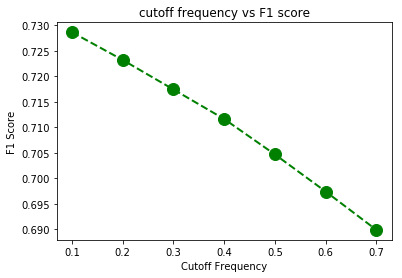

In [39]:
plt.plot(cutoff_l, f1, color='green', marker='o', linestyle='dashed',
...      linewidth=2, markersize=12)
plt.xlabel('Cutoff Frequency')
plt.ylabel('F1 Score')
plt.title("cutoff frequency vs F1 score")